#What is a Regression model?
Regression models describe the relationship between variables by fitting a line to the observed data. Linear regression models use a straight line, while logistic and nonlinear regression models use a curved line. Regression allows you to estimate how a dependent variable changes as the independent variable(s) change.

#What is Multiple Linear Regression (MLR)?
Multiple linear regression (MLR), also known simply as multiple regression, is a statistical technique that uses several explanatory variables to predict the outcome of a response variable. 

The goal of multiple linear regression (MLR) is to model the linear relationship between the explanatory (independent) variables and response (dependent) variable.

In essence, multiple regression is the extension of ordinary least-squares (OLS) regression that involves more than one explanatory variable.

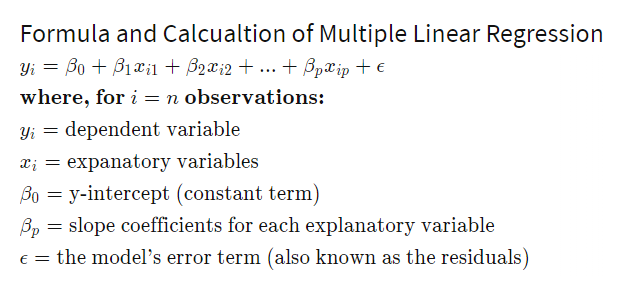

#Get The Data
Today we will work on the housing prices dataset.

In [ ]:
#get the libraries
import pandas as pd #for dataframe manipulations
import numpy as np # for linear algebra operations
import plotly.graph_objects as go # for visualization


In [ ]:
housing_df = pd.read_csv('https://raw.githubusercontent.com/Turgibot/BigData/master/DataSets/housing_complete_data.csv')

#Set your Goal
Given a few properties of a house, build a MLR model to predict it's price.

#EDA and data preparation

Learn the data

In [ ]:
housing_df.info()

In [ ]:
housing_df.head()

check for missing values


In [ ]:
housing_df.isna().any().sum()

Remove non-informative data


In [ ]:
housing_df.drop(['id','date', 'sqft_living15', 'sqft_lot15','zipcode','lat','long'], axis=1, inplace=True)
housing_df

Change the year built feature to age instead. 

Do it for year of renovation as well.

In [ ]:
import datetime
curr_year = datetime.datetime.now().year
housing_df['age'] = pd.Series(curr_year - housing_df.yr_built , name='age')

In [ ]:
ren_age = [curr_year - value if value>0 else 0 for value in housing_df.yr_renovated ]
housing_df['ren_age'] = pd.Series(ren_age , name='ren_age')


In [ ]:
housing_df.head()

In [ ]:
housing_df['priceK'] = housing_df.price/1000


In [ ]:
housing_df.drop(['yr_built','yr_renovated', 'price'], axis=1, inplace=True)
housing_df.head()

note basic statistical values 

In [ ]:
housing_df.describe()

##Scale the DF

using standarization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(housing_df), columns=housing_df.columns)
scaled_df.head()

##Detect Outliers

In [ ]:
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(scaled_df.columns))]
fig = go.Figure()
fig.add_traces(data=[go.Box( 
    y=scaled_df.iloc[:, i], 
    marker_color=c[i],
    name=scaled_df.columns[i])
    for i in range(len(scaled_df.columns))
    ])


inference:

* Outliers are important in this dataset. Buy they hold extra values that might reflect the prediction of our model and we should consider removing them.
* The floors and age variables have no outliers.

##Features Correlation matrix


In [ ]:
corr_df = scaled_df.corr()
corr_df

In [ ]:
fig = go.Figure()
fig.add_traces(go.Heatmap(
    z=corr_df, 
    x=corr_df.columns, 
    y=corr_df.columns,
    zmax=1, 
    zmin=-1
))
fig.update_layout({
    'title':"Features Correlation Heatmap"
})


Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features.

inference:

* sqft_living and sqft_above are highly correlated features and we should remove the one with less correlation to the target


In [ ]:
housing_df.drop('sqft_above', axis=1, inplace=True)

* These are the features with correlation of 0.33 and above:

In [ ]:
correlated = corr_df.priceK.loc[(abs(corr_df.priceK)>0.4)]
correlated = correlated.drop(['priceK','sqft_above']).index
correlated


#Building a Multiple Linear Regression model

##Set your X and y

In [ ]:
y = housing_df.priceK;
X = housing_df[correlated]
X

### How to guess the most accurate predictor?
* Try all possible combinations and choose the best one. Testing all the possible MLR models is inefficient. 
* Test only the few features with the highest correlation to the target
* Use visuality if possible - remember that this is a Multi-dimentional problem.
* Use statistical testing score - will be covered in the feature selection designated labs 

Let's scatter plot all the features vs the price variable


In [ ]:
from plotly.subplots import make_subplots
rows = 3
cols = 1
c = ['blue', 'green', 'brown', 'red']
fig = make_subplots(rows=rows, cols=cols, shared_yaxes=True, )
count=0
for i in range(rows):
  for j in range(cols):
    if count < len(X.columns):
      fig.add_trace(go.Scatter(
        y=y, 
        x=X.iloc[:,count],
        mode='markers',
        marker_color=c[count],
        marker_size=2.5,
        name=X.columns[count]
        ),row=i+1, col=j+1
      )
      fig.update_xaxes(title_text=X.columns[count], row=i+1, col=j+1)
    count+=1

fig.update_layout(height=600, width=900,
                  title_text="Price by features")
fig.show()

inference:

* The scatter that is more adequate to fit a straight line is the 'Price by Living Area'. 
* Note that this is in acordance with the high correlation between the pair 'Price' and 'Living Area' 

##Spilt to train and test subsets

The train_test_split function is for splitting a single dataset for two different purposes: training and testing. The testing subset is for building your model. The testing subset is for using the model on unknown data to evaluate the performance of the model.

Before proceeding we need to split our DF to two sets:

1. The training set : usually 70% of the original data. Use to train the model.
2. The testing set : the rest of the data used to test the model.

Separating the data enables you to evaluate your model generalization capabilities and have an idea of how it would perform on unseen data.

**important note**

The test information should never be seem by the training algorithm by any chance! This might occlude over-fitting and other many bad things you don't want to happen! Check this link on [Data Leakage](https://machinelearningmastery.com/data-leakage-machine-learning/) for more information.

In [ ]:
#split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1357)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
test_df.head(10)


In [ ]:
#scale the sets
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()
X_train_scaled = x_train_scaler.fit_transform(X_train)
X_test_scaled = x_test_scaler.fit_transform(X_test)
y_train_scaled = y_train_scaler.fit_transform(pd.DataFrame(y_train))
y_test_scaled = y_test_scaler.fit_transform(pd.DataFrame(y_test))


#Traning Stage
### Load Linear Regression (using th OLS method) from sklearn

ordinary least squares (OLS) is a type of linear least squares method for estimating the unknown parameters in a linear regression model. OLS chooses the parameters of a linear function of a set of explanatory variables by the principle of least squares: minimizing the sum of the squares of the differences between the observed dependent variable (values of the variable being predicted) in the given dataset and those predicted by the linear function.

We are looking for the line that describes the model with a minimum error <br/> 
Remember that a line equation is : ***$y_p = \theta_0 +\theta_1x$*** where $\theta_1$  is the slope and $\theta_0$ is y axis Interception.
<br/>
Also remember that the acutual y value might differ from the predicted value. This difference is called the Residual value: <br/>
$y_A=y_p+Res => Res = y_A-y_p$

##Fitting the model and finding the co-efficients 

For fitting(training) we must use the training set

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()  # define our model using least square method
lm.fit(X_train_scaled,y_train_scaled)              # Fit our linear model
# The coefficients
coeff = lm.coef_[0]
intercept = lm.intercept_[0]
print('Coefficients: \n', "coeff =", coeff , ",  Intercept=",intercept,"\n" )
print("The regression equation is:" ,"PriceK = " ,intercept," + ",coeff[0]," * ",correlated[0]," + ",coeff[1]," * ",correlated[1]," + ",coeff[2]," * ",correlated[2] )

## Using the regression model for prediction:


what is the predicted price of house with 3000 sqrf of living area?

In [ ]:
#use lm.predict(X_train) for all the living area data from the train set
fitted_scaled_price = lm.predict(X_train_scaled) # returns ndarray
#inverse the minmax scaler transformation
fitted_price = y_train_scaler.inverse_transform(fitted_scaled_price)


In [ ]:
#create a pandas series of the results
predicted_train_price = round(pd.Series(fitted_price[:,0], index=y_train.index, name='Predicted_train_price'),ndigits=2)


In [ ]:
#Add the results to the DF
train_df = pd.merge(left=train_df, right=predicted_train_price , left_index=True, right_index=True)


In [ ]:

train_df.head(10)

#Can we Plot the linear model?

This is a 5 dimensional problem and not comprehensivable for the limited 3d human perception capabilities...

# Exercise
In this excercise you are asked to predict the number of murder cases in US given some values of one of the independenth variables in the dataset.
'https://raw.githubusercontent.com/Turgibot/BigData/master/DataSets/USArrest.csv'

This data set contains statistics, in arrests per 100,000 residents
for assault, murder, and rape in each of the 50 US states in 1973.
Also given is the percent of the population living in urban areas.

1. Load the USArrest dataset as a dataframe, name it "arrest_df", sample it and get some basic statistical knowledge of it.
2. Is scaling is really necessary in this particular DF? why is so? 
3. Print and plot the heat map of the dataframe's corelation matrix.
4. Using the correlation data - choose the features with high corelation to the target and plot the resulted scatter graph.  
5. Split the DF into train and test subsets. and continue working on this excersize with the train subset only!.
6. Train the model using SKLearn LinearRegression module. Print the coefficients and intercept 
7. Predict the dependant variable. 


In [ ]:
#1 
arrest_df = pd.read_csv('https://raw.githubusercontent.com/Turgibot/BigData/master/DataSets/USArrest.csv')
arrest_df.head()

#Evaluation metrics - How good did our model do in predicting the target?

##What are Evaluation Metrics?
Evaluation metrics are used to measure the quality of the statistical or machine learning model. Evaluating machine learning models or algorithms is essential for any project. There are many different types of evaluation metrics available to test a model. 

##Why is it useful

It is very important to use multiple evaluation metrics to evaluate your model. This is because a model may perform well using one measurement from one evaluation metric, but may perform poorly using another measurement from another evaluation metric. Using evaluation metrics are critical in ensuring that your model is operating correctly and optimally. 



##Use the Test set on your model
It's time to test the model. Let's predict the housing prices depending on the test set.

In [ ]:
fitted_scaled_price = lm.predict(X_test_scaled)
fitted_price = y_test_scaler.inverse_transform(fitted_scaled_price)
predicted_test_price = round(pd.Series(fitted_price[:,0], index=y_test.index, name='Predicted_test_price'),ndigits=2)
test_df = pd.merge(left=test_df, right=predicted_test_price, left_index=True, right_index=True)
test_df

## What is a near perfect model
Let's artificially create a "near perfect" linear model. We will analyse it and compare the results to the real 'housing' model. 

In [ ]:
generate_random = np.random.RandomState(0)
#create 1000 random number in the range 0-10 for the independenth variable
x = pd.DataFrame(pd.Series(10 * generate_random.rand(1000)), columns=['data']) 

#create the independent variable and insert noise
y = pd.Series(3 * x['data'] + generate_random.randn(1000), name='data')

near_p_df = pd.merge(left=x, right=y, left_index=True, right_index=True)
near_p_df.columns=['x','y']
near_p_df.head()

In [ ]:

X2_train, X2_test, y2_train, y2_test = train_test_split(near_p_df[['x']], near_p_df.y, test_size=0.3, random_state=1000)
train2_df = pd.merge(left=X2_train, right=y2_train, left_index=True, right_index=True)
test2_df = pd.merge(left=X2_test, right=y2_test, left_index=True, right_index=True)
test2_df.head()

In [ ]:
lm2 = LinearRegression()  # define our model using least square method
lm2.fit(X2_train, y2_train)              # Fit our linear model
# The coefficients
coeff = lm2.coef_
intercept = lm2.intercept_
print('Coefficients: \n', "coeff =", coeff , ",  Intercept=",intercept,"\n" )
print("The regression equation is:" ,"Dependent cases = " ,intercept," + ",coeff[0]," * ",x.columns[0])

In [ ]:
y_train_predicted = pd.Series(lm2.predict(X2_train), index=y2_train.index, name='y_train_predicted')
train2_df = pd.merge(left=train2_df, right=y_train_predicted, left_index=True, right_index=True)
train2_df.head()

In [ ]:
y_test_predicted = pd.Series(lm2.predict(X2_test), index=y2_test.index, name='y_test_predicted')
test2_df = pd.merge(left=test2_df, right=y_test_predicted, left_index=True, right_index=True)
test2_df.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=train2_df.x, y=train2_df.y, mode='markers',marker_color='green', name='data'
))
fig.add_trace(go.Scatter(
    x=train2_df.x, y=train2_df.y_train_predicted, mode='lines',marker_color='red', name='predicted'
))
fig.update_layout(
    title="A 'Near Perfect' model",
    xaxis_title="X Axis",
    yaxis_title="Y Axis",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="RebeccaPurple"
    )
)

fig.show()

##Method 1: Residual Analysis
In residual analysis we are examining the error margin of the model. A smaller error means a better model

In [ ]:
#calculate the residuals
train_df['residuals'] = ??????
test_df['residuals'] = ???????


In [ ]:
#plot the residuals graph
fig= go.Figure()
fig.add_trace(
    go.Scatter(
        x=train_df.Predicted_train_price,
        y=train_df.residuals,
        mode='markers',
        name='train residuals',
        marker_color='blue',
        marker_size=1.5,
        marker_line_width=0,

    )
)
fig.add_trace(
  go.Scatter(
      x=test_df.Predicted_test_price,
      y=test_df.residuals,
      mode='markers',
      name='test residuals',
      marker_color='red',
      marker_size=1.5,
      marker_line_width=0,

  )
)

fig.add_trace(
  go.Scatter(
      x=test_df.Predicted_test_price,
      y=test_df.residuals*0,
      mode='lines',
      name='zero line',
      marker_color='black',
      marker_size=1.5,
      marker_line_width=0,

  )
)
fig.update_layout(
    title="Residuals of Predicted prices",
    xaxis_title="Predicted Price",
    yaxis_title="Residuals",
    font=dict(
        size=14,
        color="RebeccaPurple"
    )
)
fig.show()

what would a near perfect model would look like?


In [ ]:

#calculate the residuals
train2_df['residuals'] = train2_df.y_train_predicted - train2_df.y
test2_df['residuals'] = test2_df.y_test_predicted - test2_df.y


In [ ]:
#plot the residuals graph
fig= go.Figure()
fig.add_trace(
    go.Scatter(
        x=train2_df.y_train_predicted,
        y=train2_df.residuals,
        mode='markers',
        name='near perfect residuals',
        marker_color='blue',
        marker_size=7,
        marker_line_width=0,

    )
  )
fig.add_trace(
    go.Scatter(
        x=test2_df.y_test_predicted,
        y=test2_df.residuals,
        mode='markers',
        name='near perfect residuals',
        marker_color='orange',
        marker_size=7,
        marker_line_width=0,

    )
  )
 
fig.add_trace(
  go.Scatter(
      x=test2_df.y_test_predicted,
      y=0*test2_df.residuals,
      mode='lines',
      name='zero line',
      marker_color='black',
      marker_size=1.5,
      marker_line_width=0,

  )
)
fig.update_layout(
    title="Residuals of Predicted prices",
    xaxis_title="Predicted Price",
    yaxis_title="Residuals",
    font=dict(
        size=14,
        color="RebeccaPurple"
    )
)
fig.show()

##  Method 2: Cost functions metrics

Here are three common **cost functions** **evaluation** metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.



In [ ]:
from sklearn import metrics

print("------ TRAIN DATA ------")
print("MSE:",metrics.mean_squared_error(train_df.priceK, train_df.Predicted_train_price))
print("RMSE:",np.sqrt(metrics.mean_squared_error(train_df.priceK, train_df.Predicted_train_price)))
print("MAE:",metrics.mean_absolute_error(train_df.priceK, train_df.Predicted_train_price))

In [ ]:
print("------ TEST DATA ------")
print("MSE:",metrics.mean_squared_error(test_df.priceK, test_df.Predicted_test_price))
print("RMSE:",np.sqrt(metrics.mean_squared_error(test_df.priceK, test_df.Predicted_test_price)))
print("MAE:",metrics.mean_absolute_error(test_df.priceK, test_df.Predicted_test_price))

when the test metrics are worse than the train metrics we state that the model is overfitted

**what would a near perfect model would look like?**


In [ ]:
print("------ TRAIN DATA ------")
print("MSE:",metrics.mean_squared_error(train2_df.y, train2_df.y_train_predicted))
print("RMSE:",np.sqrt(metrics.mean_squared_error(train2_df.y, train2_df.y_train_predicted)))
print("MAE:",metrics.mean_absolute_error(train2_df.y, train2_df.y_train_predicted))

In [ ]:
print("------ TEST DATA ------")
print("MSE:",metrics.mean_squared_error(test2_df.y, test2_df.y_test_predicted))
print("RMSE:",np.sqrt(metrics.mean_squared_error(test2_df.y, test2_df.y_test_predicted)))
print("MAE:",metrics.mean_absolute_error(test2_df.y, test2_df.y_test_predicted))

## Method 3: Coefficient of determination, $R^2$
<a id='r'></a>

**$R^2$** is the proportion of the **variance** in the dependent variable that is predictable from the independent variable(s).
$$R^2 = 1-\frac{\sum_{i=1}^n(y_i-\hat{y}_i)^2}{\sum_{i=1}^n(y_i-\bar{y})^2} = 1-\frac{SSE}{SST}$$

SSE: Sum of Squared Errors
<br>
SST: Total Sum of Squares


In [ ]:
#get R2 for train set
from sklearn.metrics import r2_score
r2_score(train_df.priceK, train_df.Predicted_train_price)

In [ ]:
#get R2 for test set
r2_score(test_df.priceK, test_df.Predicted_test_price)

**what would a near perfect model would look like?**


In [ ]:
r2_score(train2_df.y, train2_df.y_train_predicted)

In [ ]:
r2_score(test2_df.y, test2_df.y_test_predicted)